In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

print("="*80)
print("KLASTEROVANJE FARM-ADS PODATAKA")
print("="*80)

KLASTEROVANJE FARM-ADS PODATAKA


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("\n1. Učitavanje podataka...")

data = []
file_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/farm+ads/farm-ads'

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            label = int(parts[0])
            text = parts[1]
            data.append({'label': label, 'text': text})

df_original = pd.DataFrame(data)
print(f"Ukupan broj dokumenata: {len(df_original)}")
print(f"Distribucija labela:")
print(df_original['label'].value_counts())
print(f"\nPrimer prvog dokumenta:")
print(f"Label: {df_original.iloc[0]['label']}")
print(f"Text (prvih 200 karaktera): {df_original.iloc[0]['text'][:200]}...")

output_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/data_original.csv'
df_original.to_csv(output_path, index=False)
print(f"\nOriginalni podaci sačuvani u: {output_path}")


1. Učitavanje podataka...
Ukupan broj dokumenata: 4143
Distribucija labela:
label
 1    2210
-1    1933
Name: count, dtype: int64

Primer prvog dokumenta:
Label: 1
Text (prvih 200 karaktera): ad-jerry ad-bruckheimer ad-chase ad-premier ad-sept ad-th ad-clip ad-bruckheimer ad-chase page found...

Originalni podaci sačuvani u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/data_original.csv


In [5]:
print("\n2. Preprocesiranje podataka...")

df_original['text_length'] = df_original['text'].apply(len)
df_original['word_count'] = df_original['text'].apply(lambda x: len(x.split()))
df_original['unique_words'] = df_original['text'].apply(lambda x: len(set(x.split())))

print(f"\nStatistike teksta:")
print(f"Prosečna dužina teksta: {df_original['text_length'].mean():.2f} karaktera")
print(f"Prosečan broj reči: {df_original['word_count'].mean():.2f}")
print(f"Prosečan broj jedinstvenih reči: {df_original['unique_words'].mean():.2f}")

print("\n2.1 TF-IDF vektorizacija - svi atributi...")
tfidf_full = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8,
                              ngram_range=(1, 2), stop_words='english')
X_tfidf_full = tfidf_full.fit_transform(df_original['text']).toarray()
print(f"Dimenzije TF-IDF (full): {X_tfidf_full.shape}")

print("\n2.2 TF-IDF vektorizacija - redukovani skup...")
tfidf_reduced = TfidfVectorizer(max_features=100, min_df=5, max_df=0.7,
                                 ngram_range=(1, 1), stop_words='english')
X_tfidf_reduced = tfidf_reduced.fit_transform(df_original['text']).toarray()
print(f"Dimenzije TF-IDF (reduced): {X_tfidf_reduced.shape}")

print("\n2.3 Count Vectorization...")
count_vec = CountVectorizer(max_features=200, min_df=2, max_df=0.8, stop_words='english')
X_count = count_vec.fit_transform(df_original['text']).toarray()
print(f"Dimenzije Count Vec: {X_count.shape}")

print("\n2.4 TF-IDF + statistički atributi...")
stats_features = df_original[['text_length', 'word_count', 'unique_words']].values
scaler = StandardScaler()
stats_features_scaled = scaler.fit_transform(stats_features)
X_tfidf_stats = np.hstack([X_tfidf_reduced, stats_features_scaled])
print(f"Dimenzije TF-IDF+Stats: {X_tfidf_stats.shape}")

print("\n2.5 PCA redukcija...")
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf_full)
print(f"Dimenzije PCA: {X_pca.shape}")
print(f"Objašnjena varijansa (kumulativno): {pca.explained_variance_ratio_.sum():.4f}")

print("\n2.6 SVD (LSA) redukcija...")
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf_full)
print(f"Dimenzije SVD: {X_svd.shape}")
print(f"Objašnjena varijansa (kumulativno): {svd.explained_variance_ratio_.sum():.4f}")

df_preprocessed = df_original.copy()
for i in range(X_tfidf_full.shape[1]):
    df_preprocessed[f'tfidf_{i}'] = X_tfidf_full[:, i]

output_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/data_preprocessed.csv'
df_preprocessed.to_csv(output_path, index=False)
print(f"\nPreprocesirani podaci sačuvani u: {output_path}")


2. Preprocesiranje podataka...

Statistike teksta:
Prosečna dužina teksta: 3219.68 karaktera
Prosečan broj reči: 451.46
Prosečan broj jedinstvenih reči: 197.23

2.1 TF-IDF vektorizacija - svi atributi...
Dimenzije TF-IDF (full): (4143, 500)

2.2 TF-IDF vektorizacija - redukovani skup...
Dimenzije TF-IDF (reduced): (4143, 100)

2.3 Count Vectorization...
Dimenzije Count Vec: (4143, 200)

2.4 TF-IDF + statistički atributi...
Dimenzije TF-IDF+Stats: (4143, 103)

2.5 PCA redukcija...
Dimenzije PCA: (4143, 50)
Objašnjena varijansa (kumulativno): 0.5581

2.6 SVD (LSA) redukcija...
Dimenzije SVD: (4143, 50)
Objašnjena varijansa (kumulativno): 0.5563

Preprocesirani podaci sačuvani u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/data_preprocessed.csv



3. Vizualizacija podataka...
   Računanje t-SNE...
2D vizualizacija sačuvana u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/viz_2d.png
3D vizualizacija sačuvana u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/viz_3d.png


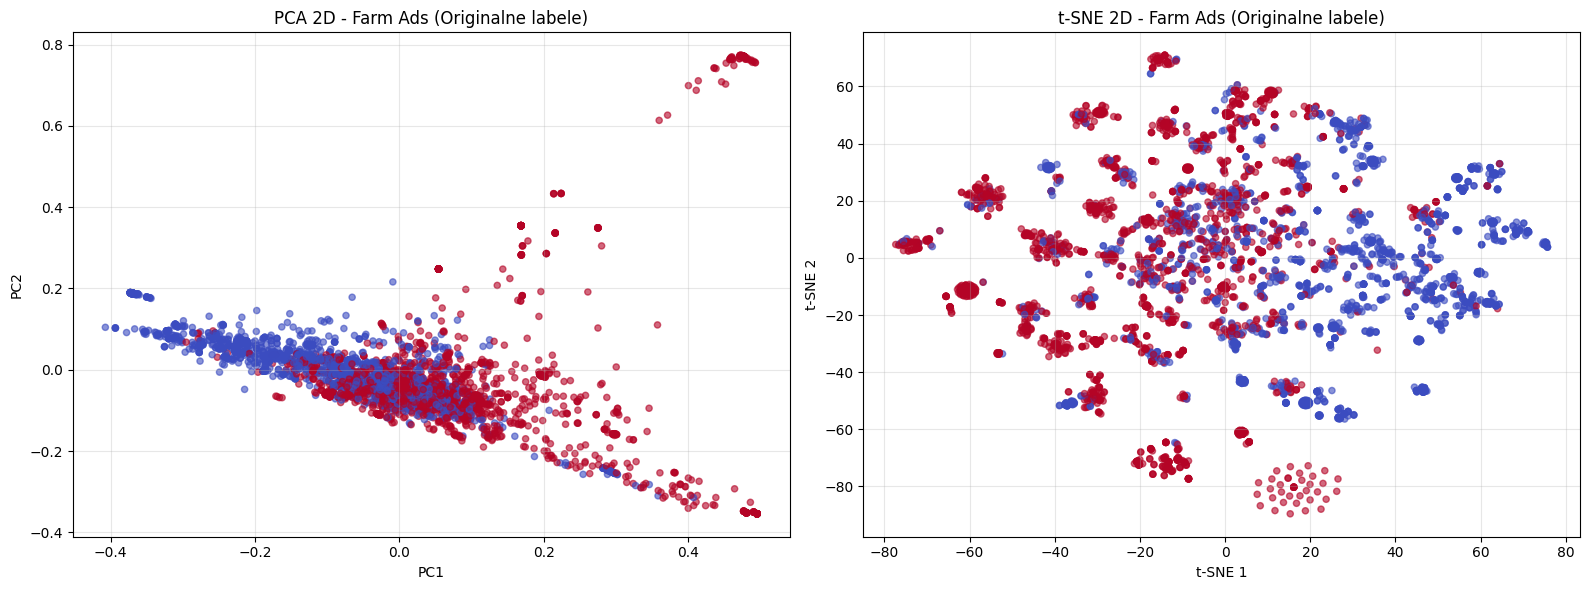

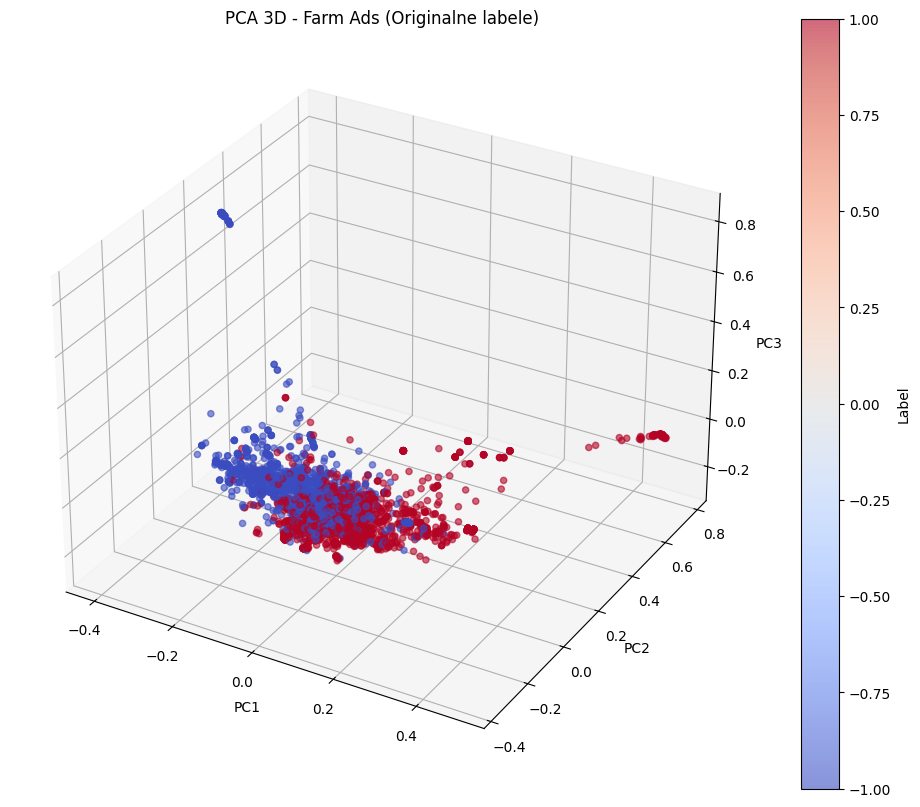

In [6]:
print("\n3. Vizualizacija podataka...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_tfidf_full)

axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                c=df_original['label'], cmap='coolwarm', alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA 2D - Farm Ads (Originalne labele)')
axes[0].grid(True, alpha=0.3)

print("   Računanje t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_tfidf_reduced)

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1],
                c=df_original['label'], cmap='coolwarm', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE 2D - Farm Ads (Originalne labele)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
viz_2d_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/viz_2d.png'
plt.savefig(viz_2d_path, dpi=300, bbox_inches='tight')
print(f"2D vizualizacija sačuvana u: {viz_2d_path}")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_tfidf_full)

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=df_original['label'], cmap='coolwarm', alpha=0.6, s=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D - Farm Ads (Originalne labele)')
plt.colorbar(scatter, ax=ax, label='Label')
viz_3d_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/viz_3d.png'
plt.savefig(viz_3d_path, dpi=300, bbox_inches='tight')
print(f"3D vizualizacija sačuvana u: {viz_3d_path}")


4. Klasterovanje sa različitim algoritmima...

4.1 Određivanje optimalnog broja klastera (Elbow metoda)...
Elbow dijagram sačuvan u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/elbow_method.png

Optimalan broj klastera: 10


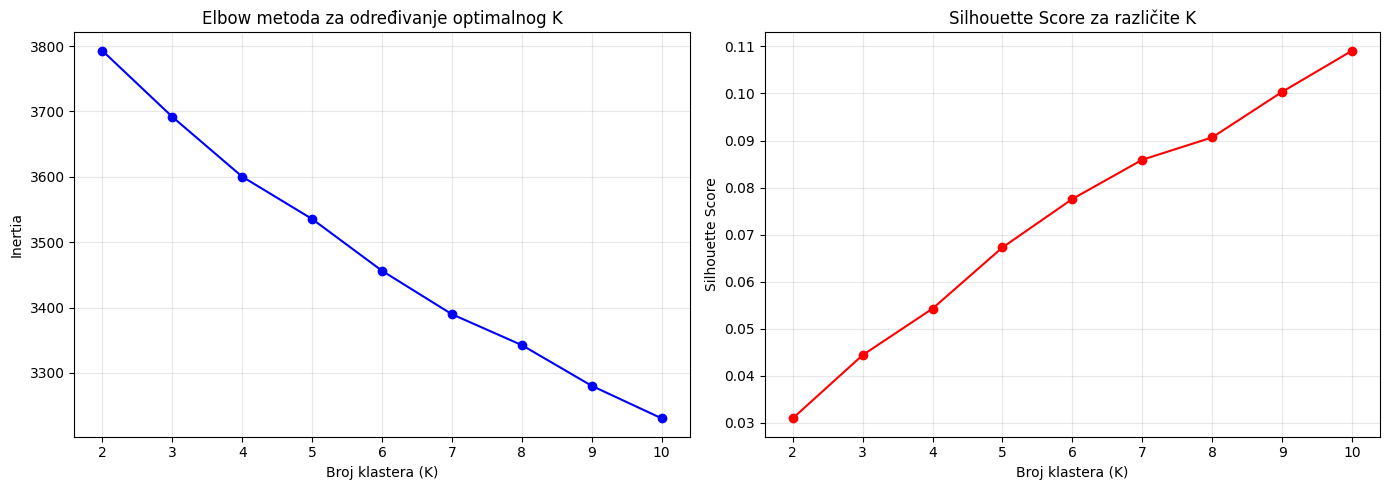

In [7]:
print("\n4. Klasterovanje sa različitim algoritmima...")

datasets = {
    'TF-IDF Full (500 feat)': X_tfidf_full,
    'TF-IDF Reduced (100 feat)': X_tfidf_reduced,
    'Count Vec (200 feat)': X_count,
    'TF-IDF + Stats': X_tfidf_stats,
    'PCA (50 comp)': X_pca,
    'SVD (50 comp)': X_svd
}

print("\n4.1 Određivanje optimalnog broja klastera (Elbow metoda)...")
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf_full)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_tfidf_full, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Broj klastera (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow metoda za određivanje optimalnog K')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes, 'ro-')
axes[1].set_xlabel('Broj klastera (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score za različite K')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
elbow_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/elbow_method.png'
plt.savefig(elbow_path, dpi=300, bbox_inches='tight')
print(f"Elbow dijagram sačuvan u: {elbow_path}")

optimal_k = K_range[np.argmax(silhouettes)]
print(f"\nOptimalan broj klastera: {optimal_k}")

In [ ]:
print("\n5. Primena algoritama klasterovanja...")

algorithms = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    'K-Means (k=3)': KMeans(n_clusters=3, random_state=42, n_init=10),
    'Agglomerative (Ward)': AgglomerativeClustering(n_clusters=optimal_k, linkage='ward'),
    'Agglomerative (Complete)': AgglomerativeClustering(n_clusters=optimal_k, linkage='complete'),
    'DBSCAN (eps=0.5)': DBSCAN(eps=0.5, min_samples=5),
    'DBSCAN (eps=1.0)': DBSCAN(eps=1.0, min_samples=10),
    'Mean Shift': MeanShift(bandwidth=2.0),
    'BIRCH': Birch(n_clusters=optimal_k, threshold=0.5)
}

results = []

print("\nTrenutak, izvršavam klasterovanje sa 8 algoritama na 6 skupova podataka...")
print("Ovo može trajati nekoliko minuta...\n")

for dataset_name, X_data in datasets.items():
    print(f"\n{'='*70}")
    print(f"Skup podataka: {dataset_name}")
    print(f"{'='*70}")

    for alg_name, algorithm in algorithms.items():
        try:
            if hasattr(algorithm, 'fit_predict'):
                labels = algorithm.fit_predict(X_data)
            else:
                algorithm.fit(X_data)
                labels = algorithm.labels_

            n_clusters = len(np.unique(labels[labels >= 0]))

            if n_clusters > 1 and n_clusters < len(X_data):
                mask = labels >= 0
                if mask.sum() > n_clusters:
                    silhouette = silhouette_score(X_data[mask], labels[mask])
                    davies_bouldin = davies_bouldin_score(X_data[mask], labels[mask])
                    calinski = calinski_harabasz_score(X_data[mask], labels[mask])
                else:
                    silhouette = davies_bouldin = calinski = np.nan
            else:
                silhouette = davies_bouldin = calinski = np.nan

            n_noise = np.sum(labels == -1)

            results.append({
                'Dataset': dataset_name,
                'Algorithm': alg_name,
                'N_Clusters': n_clusters,
                'N_Noise': n_noise,
                'Silhouette': silhouette,
                'Davies-Bouldin': davies_bouldin,
                'Calinski-Harabasz': calinski
            })

            print(f"  {alg_name:30s} | Klasteri: {n_clusters:2d} | Noise: {n_noise:4d} | "
                  f"Silhouette: {silhouette:7.4f}" if not np.isnan(silhouette)
                  else f"  {alg_name:30s} | Klasteri: {n_clusters:2d} | Noise: {n_noise:4d} | Silhouette: N/A")

        except Exception as e:
            print(f"  {alg_name:30s} | ERROR: {str(e)[:50]}")
            results.append({
                'Dataset': dataset_name,
                'Algorithm': alg_name,
                'N_Clusters': 0,
                'N_Noise': 0,
                'Silhouette': np.nan,
                'Davies-Bouldin': np.nan,
                'Calinski-Harabasz': np.nan
            })


5. Primena algoritama klasterovanja...

Trenutak, izvršavam klasterovanje sa 8 algoritama na 6 skupova podataka...
Ovo može trajati nekoliko minuta...


Skup podataka: TF-IDF Full (500 feat)
  K-Means                        | Klasteri: 10 | Noise:    0 | Silhouette:  0.1091
  K-Means (k=3)                  | Klasteri:  3 | Noise:    0 | Silhouette:  0.0444
  Agglomerative (Ward)           | Klasteri: 10 | Noise:    0 | Silhouette:  0.1107
  Agglomerative (Complete)       | Klasteri: 10 | Noise:    0 | Silhouette:  0.0382
  DBSCAN (eps=0.5)               | Klasteri: 131 | Noise: 2023 | Silhouette:  0.7893
  DBSCAN (eps=1.0)               | Klasteri:  1 | Noise:  155 | Silhouette: N/A
  Mean Shift                     | Klasteri:  1 | Noise:    0 | Silhouette: N/A
  BIRCH                          | Klasteri: 10 | Noise:    0 | Silhouette:  0.0471

Skup podataka: TF-IDF Reduced (100 feat)
  K-Means                        | Klasteri: 10 | Noise:    0 | Silhouette:  0.1421
  K-Means (k=3)  

In [ ]:
print("\n" + "="*80)
print("6. ANALIZA REZULTATA")
print("="*80)

df_results = pd.DataFrame(results)
results_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/clustering_results.csv'
df_results.to_csv(results_path, index=False)
print(f"\n✓ Rezultati sačuvani u: {results_path}")

print("\n6.1 TOP 10 MODELA (po Silhouette score-u):")
print("-" * 80)
top_models = df_results.dropna(subset=['Silhouette']).nlargest(10, 'Silhouette')
for idx, row in top_models.iterrows():
    print(f"{row['Algorithm']:30s} | {row['Dataset']:25s} | "
          f"Silhouette: {row['Silhouette']:.4f} | "
          f"Davies-Bouldin: {row['Davies-Bouldin']:.4f}")

print("\n6.2 TOP 10 MODELA (po Davies-Bouldin score-u - manji je bolji):")
print("-" * 80)
top_db = df_results.dropna(subset=['Davies-Bouldin']).nsmallest(10, 'Davies-Bouldin')
for idx, row in top_db.iterrows():
    print(f"{row['Algorithm']:30s} | {row['Dataset']:25s} | "
          f"Davies-Bouldin: {row['Davies-Bouldin']:.4f} | "
          f"Silhouette: {row['Silhouette']:.4f}")

print("\n6.3 TOP 10 MODELA (po Calinski-Harabasz score-u - veći je bolji):")
print("-" * 80)
top_ch = df_results.dropna(subset=['Calinski-Harabasz']).nlargest(10, 'Calinski-Harabasz')
for idx, row in top_ch.iterrows():
    print(f"{row['Algorithm']:30s} | {row['Dataset']:25s} | "
          f"Calinski-Harabasz: {row['Calinski-Harabasz']:.2f} | "
          f"Silhouette: {row['Silhouette']:.4f}")


6. ANALIZA REZULTATA

✓ Rezultati sačuvani u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/clustering_results.csv

6.1 TOP 10 MODELA (po Silhouette score-u):
--------------------------------------------------------------------------------
DBSCAN (eps=0.5)               | Count Vec (200 feat)      | Silhouette: 1.0000 | Davies-Bouldin: 0.0000
K-Means (k=3)                  | Count Vec (200 feat)      | Silhouette: 0.9137 | Davies-Bouldin: 0.4769
DBSCAN (eps=1.0)               | Count Vec (200 feat)      | Silhouette: 0.8043 | Davies-Bouldin: 0.4332
DBSCAN (eps=0.5)               | TF-IDF Full (500 feat)    | Silhouette: 0.7893 | Davies-Bouldin: 0.4419
Agglomerative (Complete)       | Count Vec (200 feat)      | Silhouette: 0.7885 | Davies-Bouldin: 0.7054
DBSCAN (eps=0.5)               | TF-IDF + Stats            | Silhouette: 0.7438 | Davies-Bouldin: 0.5047
DBSCAN (eps=0.5)               | TF-IDF Reduced (100 feat) | Silhouette: 0.6292 | Davies-Bouldin: 0.6242
Mean Shift        


7. Vizualizacija poređenja algoritama...
✓ Poređenje algoritama sačuvano u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/algorithm_comparison.png
✓ Heatmap poređenje sačuvano u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/heatmap_comparison.png


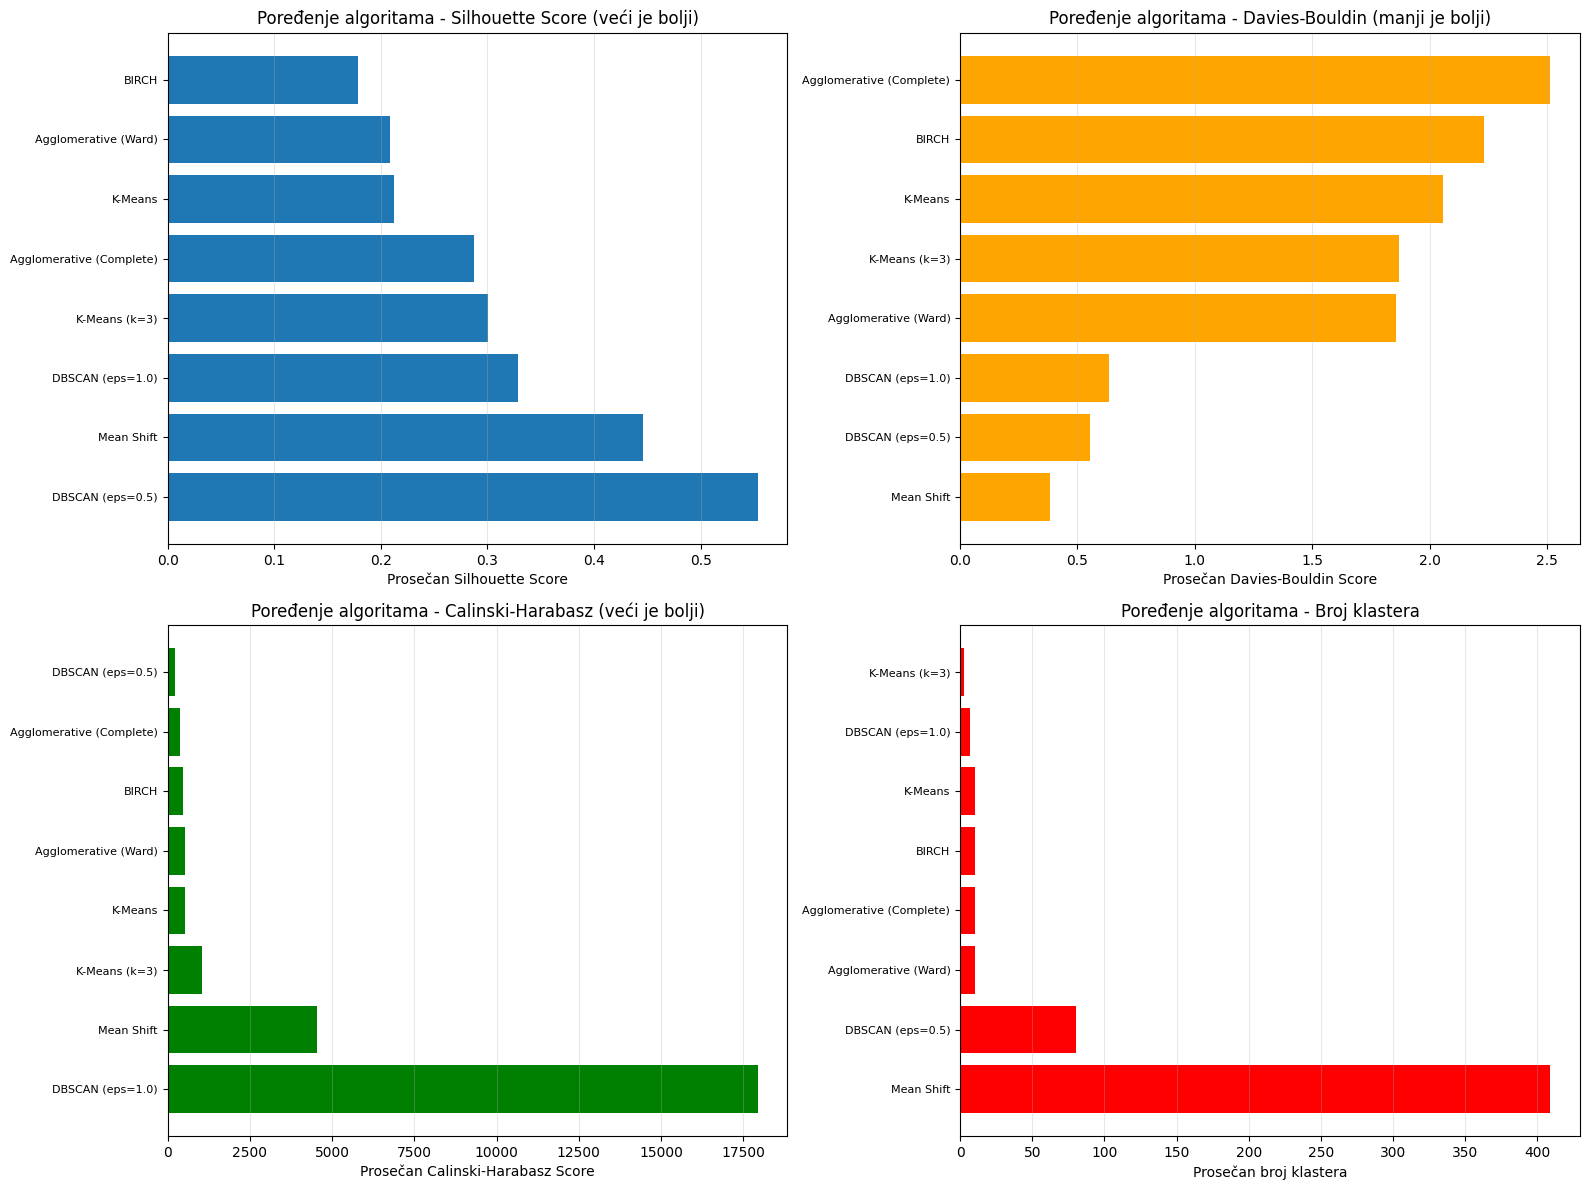

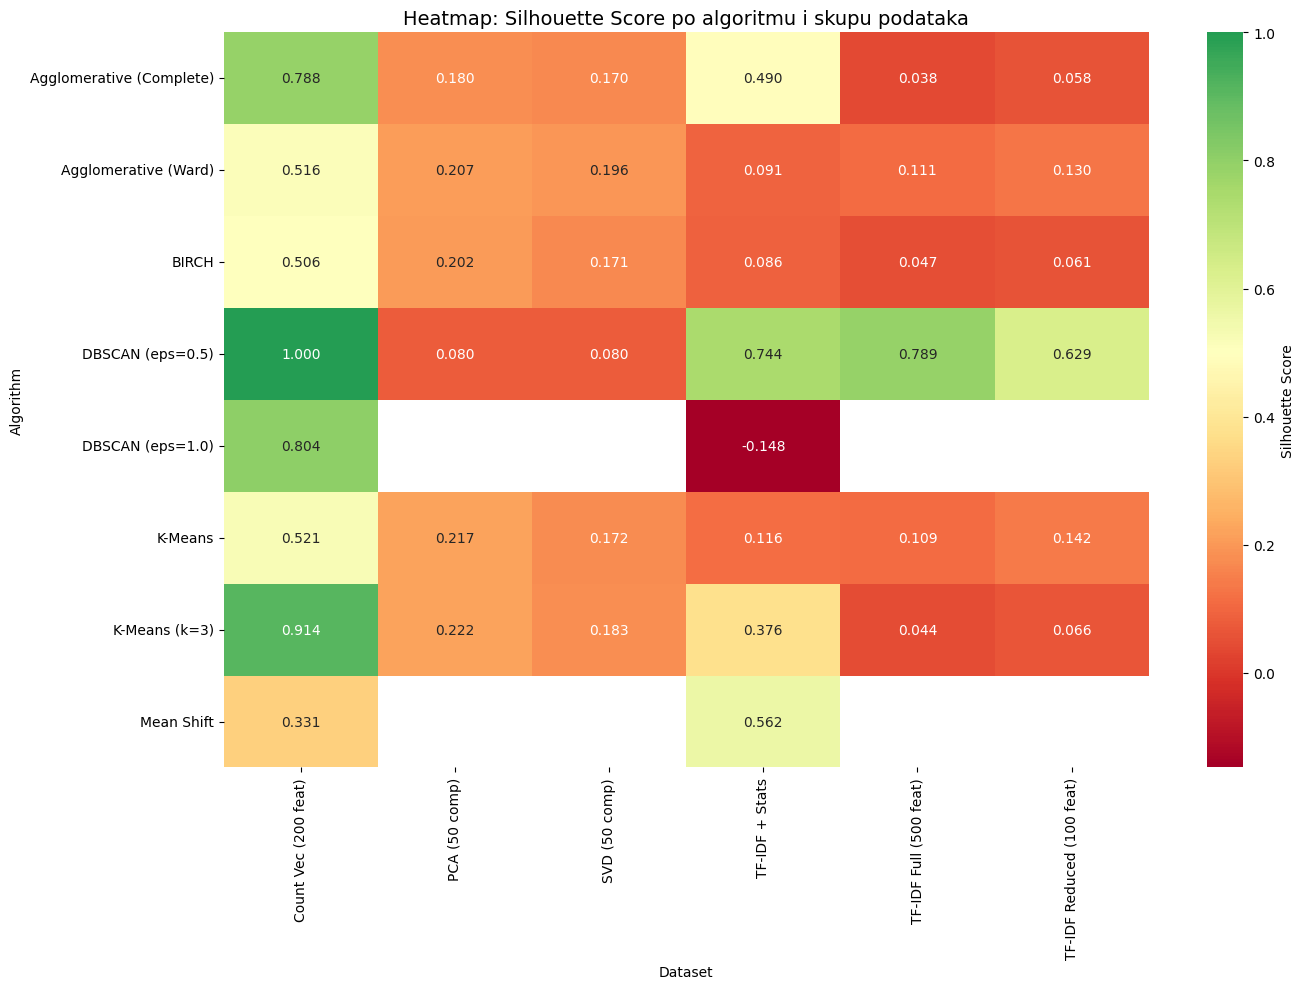

In [ ]:
print("\n7. Vizualizacija poređenja algoritama...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

alg_silhouette = df_results.groupby('Algorithm')['Silhouette'].mean().sort_values(ascending=False)
axes[0, 0].barh(range(len(alg_silhouette)), alg_silhouette.values)
axes[0, 0].set_yticks(range(len(alg_silhouette)))
axes[0, 0].set_yticklabels(alg_silhouette.index, fontsize=8)
axes[0, 0].set_xlabel('Prosečan Silhouette Score')
axes[0, 0].set_title('Poređenje algoritama - Silhouette Score (veći je bolji)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

alg_db = df_results.groupby('Algorithm')['Davies-Bouldin'].mean().sort_values()
axes[0, 1].barh(range(len(alg_db)), alg_db.values, color='orange')
axes[0, 1].set_yticks(range(len(alg_db)))
axes[0, 1].set_yticklabels(alg_db.index, fontsize=8)
axes[0, 1].set_xlabel('Prosečan Davies-Bouldin Score')
axes[0, 1].set_title('Poređenje algoritama - Davies-Bouldin (manji je bolji)')
axes[0, 1].grid(True, alpha=0.3, axis='x')

alg_ch = df_results.groupby('Algorithm')['Calinski-Harabasz'].mean().sort_values(ascending=False)
axes[1, 0].barh(range(len(alg_ch)), alg_ch.values, color='green')
axes[1, 0].set_yticks(range(len(alg_ch)))
axes[1, 0].set_yticklabels(alg_ch.index, fontsize=8)
axes[1, 0].set_xlabel('Prosečan Calinski-Harabasz Score')
axes[1, 0].set_title('Poređenje algoritama - Calinski-Harabasz (veći je bolji)')
axes[1, 0].grid(True, alpha=0.3, axis='x')

alg_clusters = df_results.groupby('Algorithm')['N_Clusters'].mean().sort_values(ascending=False)
axes[1, 1].barh(range(len(alg_clusters)), alg_clusters.values, color='red')
axes[1, 1].set_yticks(range(len(alg_clusters)))
axes[1, 1].set_yticklabels(alg_clusters.index, fontsize=8)
axes[1, 1].set_xlabel('Prosečan broj klastera')
axes[1, 1].set_title('Poređenje algoritama - Broj klastera')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
comparison_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/algorithm_comparison.png'
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
print(f"Poređenje algoritama sačuvano u: {comparison_path}")

fig, ax = plt.subplots(figsize=(14, 10))
pivot_table = df_results.pivot_table(values='Silhouette', index='Algorithm',
                                      columns='Dataset', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'Silhouette Score'}, ax=ax)
ax.set_title('Heatmap: Silhouette Score po algoritmu i skupu podataka', fontsize=14)
plt.tight_layout()
heatmap_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/heatmap_comparison.png'
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"Heatmap poređenje sačuvano u: {heatmap_path}")


8. Vizualizacija najboljeg modela...

Najbolji model:
  Algoritam: DBSCAN (eps=0.5)
  Skup podataka: Count Vec (200 feat)
  Silhouette Score: 1.0000
✓ Vizualizacija najboljeg modela sačuvana u: /content/drive/MyDrive/Colab Notebooks/IP2_Projekat/best_model_visualization.png


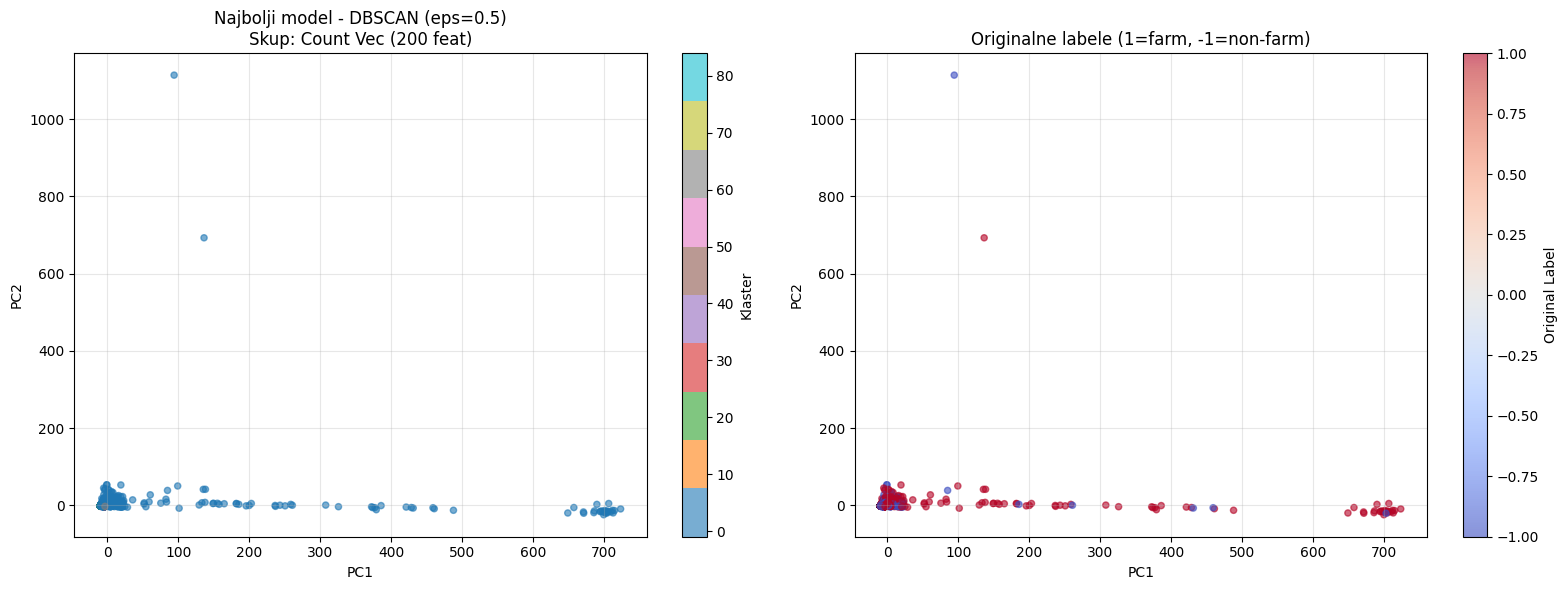

In [ ]:
print("\n8. Vizualizacija najboljeg modela...")

best_model_row = df_results.dropna(subset=['Silhouette']).nlargest(1, 'Silhouette').iloc[0]
print(f"\nNajbolji model:")
print(f"  Algoritam: {best_model_row['Algorithm']}")
print(f"  Skup podataka: {best_model_row['Dataset']}")
print(f"  Silhouette Score: {best_model_row['Silhouette']:.4f}")

best_dataset = datasets[best_model_row['Dataset']]
best_algorithm_name = best_model_row['Algorithm']

if 'K-Means' in best_algorithm_name:
    k_val = optimal_k if 'k=' not in best_algorithm_name else int(best_algorithm_name.split('k=')[1].split(')')[0])
    best_algorithm = KMeans(n_clusters=k_val, random_state=42, n_init=10)
elif 'Agglomerative' in best_algorithm_name:
    linkage = 'ward' if 'Ward' in best_algorithm_name else 'complete'
    best_algorithm = AgglomerativeClustering(n_clusters=optimal_k, linkage=linkage)
elif 'DBSCAN' in best_algorithm_name:
    eps_val = 0.5 if 'eps=0.5' in best_algorithm_name else 1.0
    min_s = 5 if 'eps=0.5' in best_algorithm_name else 10
    best_algorithm = DBSCAN(eps=eps_val, min_samples=min_s)
elif 'Mean Shift' in best_algorithm_name:
    best_algorithm = MeanShift(bandwidth=2.0)
else:
    best_algorithm = Birch(n_clusters=optimal_k, threshold=0.5)

if hasattr(best_algorithm, 'fit_predict'):
    best_labels = best_algorithm.fit_predict(best_dataset)
else:
    best_algorithm.fit(best_dataset)
    best_labels = best_algorithm.labels_

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pca_best = PCA(n_components=2, random_state=42)
X_pca_best = pca_best.fit_transform(best_dataset)

scatter1 = axes[0].scatter(X_pca_best[:, 0], X_pca_best[:, 1],
                           c=best_labels, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'Najbolji model - {best_algorithm_name}\nSkup: {best_model_row["Dataset"]}')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Klaster')

scatter2 = axes[1].scatter(X_pca_best[:, 0], X_pca_best[:, 1],
                           c=df_original['label'], cmap='coolwarm', alpha=0.6, s=20)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Originalne labele (1=farm, -1=non-farm)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Original Label')

plt.tight_layout()
best_model_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/best_model_visualization.png'
plt.savefig(best_model_path, dpi=300, bbox_inches='tight')
print(f"Vizualizacija najboljeg modela sačuvana u: {best_model_path}")

In [ ]:
print("\n9. Analiza klastera najboljeg modela...")

df_clustered = df_original.copy()
df_clustered['cluster'] = best_labels

print("\nDistribucija dokumenata po klasterima:")
cluster_dist = df_clustered['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    pct = (count / len(df_clustered)) * 100
    print(f"  Klaster {cluster_id}: {count:4d} dokumenata ({pct:5.2f}%)")

print("\nOdnos klastera i originalnih labela:")
crosstab = pd.crosstab(df_clustered['cluster'], df_clustered['label'], margins=True)
print(crosstab)

clustered_path = '/content/drive/MyDrive/Colab Notebooks/IP2_Projekat/data_clustered.csv'
df_clustered.to_csv(clustered_path, index=False)
print(f"\n Klasterovani podaci sačuvani u: {clustered_path}")

if 'TF-IDF' in best_model_row['Dataset']:
    print("\n10. Top 10 reči po klasterima...")

    if 'Full' in best_model_row['Dataset']:
        vectorizer = tfidf_full
    else:
        vectorizer = tfidf_reduced

    feature_names = vectorizer.get_feature_names_out()

    for cluster_id in sorted(df_clustered['cluster'].unique()):
        if cluster_id >= 0:
            cluster_docs = df_clustered[df_clustered['cluster'] == cluster_id]['text']

            cluster_tfidf = vectorizer.transform(cluster_docs)
            avg_tfidf = cluster_tfidf.mean(axis=0).A1

            top_indices = avg_tfidf.argsort()[-10:][::-1]
            top_words = [feature_names[i] for i in top_indices]

            print(f"\nKlaster {cluster_id} ({len(cluster_docs)} dokumenata):")
            print(f"  Top reči: {', '.join(top_words)}")


9. Analiza klastera najboljeg modela...

Distribucija dokumenata po klasterima:
  Klaster -1: 3377 dokumenata (81.51%)
  Klaster 0:   13 dokumenata ( 0.31%)
  Klaster 1:   13 dokumenata ( 0.31%)
  Klaster 2:    5 dokumenata ( 0.12%)
  Klaster 3:   11 dokumenata ( 0.27%)
  Klaster 4:   11 dokumenata ( 0.27%)
  Klaster 5:   10 dokumenata ( 0.24%)
  Klaster 6:    8 dokumenata ( 0.19%)
  Klaster 7:   34 dokumenata ( 0.82%)
  Klaster 8:    7 dokumenata ( 0.17%)
  Klaster 9:    9 dokumenata ( 0.22%)
  Klaster 10:    6 dokumenata ( 0.14%)
  Klaster 11:    6 dokumenata ( 0.14%)
  Klaster 12:    5 dokumenata ( 0.12%)
  Klaster 13:    9 dokumenata ( 0.22%)
  Klaster 14:    5 dokumenata ( 0.12%)
  Klaster 15:    9 dokumenata ( 0.22%)
  Klaster 16:   33 dokumenata ( 0.80%)
  Klaster 17:    9 dokumenata ( 0.22%)
  Klaster 18:   35 dokumenata ( 0.84%)
  Klaster 19:   32 dokumenata ( 0.77%)
  Klaster 20:   13 dokumenata ( 0.31%)
  Klaster 21:    9 dokumenata ( 0.22%)
  Klaster 22:   10 dokumenata ( 